In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/human_lymph_201014_06.h5ad')
adata

AnnData object with n_obs × n_vars = 25273 × 4015
    obs: 'Cell_Type', 'cell_type', 'cell_type_int'
    uns: 'Cell_Type_colors'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 1min 37s, sys: 10.6 s, total: 1min 48s
Wall time: 1min 13s


In [7]:
adata.layers["raw_count"].max()

67.0

4015 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


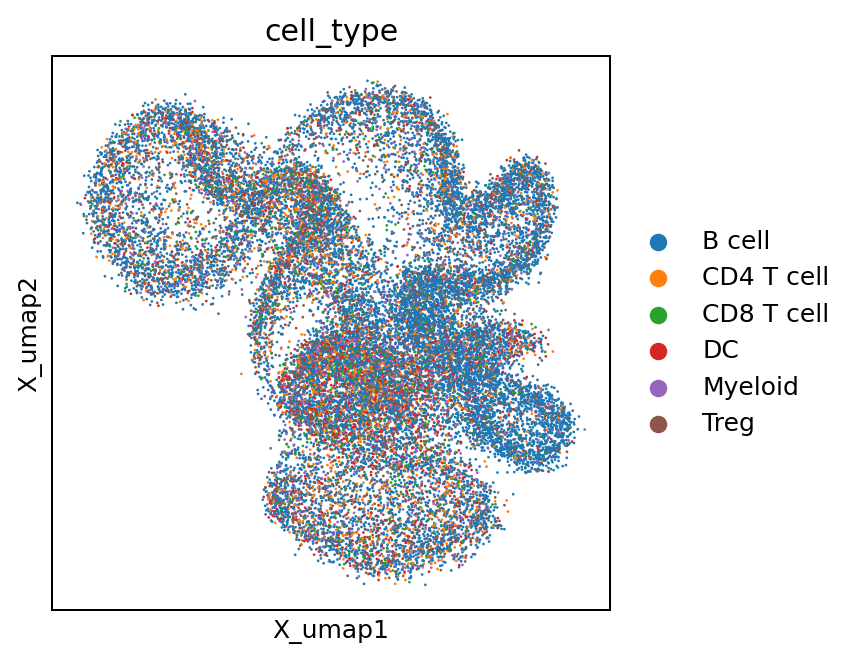

In [8]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [9]:
adata

AnnData object with n_obs × n_vars = 25273 × 4015
    obs: 'Cell_Type', 'cell_type', 'cell_type_int'
    uns: 'Cell_Type_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [10]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [11]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=2
)

  0%|          | 0/6 [00:00<?, ?it/s]

Inferring GRN for B cell...


  0%|          | 0/3724 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [08:58<44:50, 538.14s/it]

Inferring GRN for CD4 T cell...


  0%|          | 0/3724 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [11:17<20:14, 303.55s/it]

Inferring GRN for CD8 T cell...


  0%|          | 0/3724 [00:00<?, ?it/s]

 50%|█████     | 3/6 [13:16<10:57, 219.11s/it]

Inferring GRN for DC...


  0%|          | 0/3724 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [15:19<06:02, 181.16s/it]

Inferring GRN for Myeloid...


  0%|          | 0/3724 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [17:24<02:41, 161.15s/it]

Inferring GRN for Treg...


  0%|          | 0/3724 [00:00<?, ?it/s]

100%|██████████| 6/6 [19:47<00:00, 197.92s/it]

CPU times: user 8min 6s, sys: 40.6 s, total: 8min 47s
Wall time: 19min 48s


In [12]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
import pickle

with open('/Users/koush/Desktop/training_data/human_lymph_201014_06_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [14]:
adata

AnnData object with n_obs × n_vars = 25273 × 4015
    obs: 'Cell_Type', 'cell_type', 'cell_type_int'
    uns: 'Cell_Type_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [15]:
links.links_dict.keys()

dict_keys(['B cell', 'CD4 T cell', 'CD8 T cell', 'DC', 'Myeloid', 'Treg'])